In [1]:
import pandas as pd
import numpy as np
import ast 

# Redefining the conversion function to produce a list of lists of integers
def convert_to_list_of_lists(array_str):
    # Remove the 'array' and surrounding brackets
    array_str = array_str.replace('array(', '').replace(')', '')
    # Use ast.literal_eval to safely evaluate the string as a Python expression
    evaluated = ast.literal_eval(array_str)
    # Convert the tuples of arrays into lists of lists
    return [list(arr) for arr in evaluated]

df = pd.read_csv('Traj_Results.csv')
df['traj'] = df['traj'].astype(str).apply(convert_to_list_of_lists)
df['traj'] = df['traj'].apply(lambda x: np.array(x))
df['centered_traj'] = df['traj'].apply(lambda x: np.array([sub_array - sub_array.mean() for sub_array in x]))
df.head()

,Unnamed: 0,name,date,quantity,exposure,tracked_id,traj,VCL,VAP,VSL,LIN,STR,WOB,BeatCross,ALH,img,cluster,centered_traj
0,0,Balder,03032020_1,0,0m,1.0,"[[217, 217, 218, 217, 217, 218, 217, 217, 217,...",60.816720,26.542675,24.077578,0.395904,0.907127,0.436437,49.024390,2.507319,[1. 1. 1. ... 1. 1. 1.],0,"[[4.764705882352928, 4.764705882352928, 5.7647..."
1,1,Balder,03032020_1,0,0m,2.0,"[[547, 547, 546, 547, 547, 546, 548, 547, 547,...",65.542230,34.366753,25.329240,0.386457,0.737027,0.524345,45.494507,2.760374,[1. 1. 1. ... 1. 1. 1.],0,"[[12.287234042553223, 12.287234042553223, 11.2..."
2,2,Balder,03032020_1,0,0m,3.0,"[[261, 261, 261, 261, 261, 261, 261, 261, 260,...",69.336380,44.143960,28.248203,0.407408,0.639911,0.636664,39.428570,2.817186,[1. 1. 1. ... 1. 1. 1.],0,"[[10.794520547945211, 10.794520547945211, 10.7..."
3,3,Balder,03032020_1,0,0m,7.0,"[[608, 608, 608, 608, 608, 608, 608, 608, 608,...",52.817290,14.678791,11.211498,0.212269,0.763789,0.277916,47.256638,1.513670,[1. 1. 1. ... 1. 1. 1.],0,"[[6.865546218487339, 6.865546218487339, 6.8655..."
4,4,Balder,03032020_1,0,0m,8.0,"[[140, 140, 142, 142, 144, 143, 146, 146, 147,...",110.559395,76.505140,63.407223,0.573513,0.828797,0.691982,25.945946,4.752110,[1. 1. 1. ... 1. 1. 1.],0,"[[-9.699999999999989, -9.699999999999989, -7.6..."


In [2]:
i_traj = df["centered_traj"].values
cen_traj = [element.transpose().tolist() for element in i_traj]


In [3]:
def apply_cyclic_padding(trajectory, pad_percentage=5):
    # Ensure the trajectory is a list
    trajectory = list(trajectory)
    
    # Calculate pad length based on percentage
    pad_length = max(1, int(len(trajectory) * pad_percentage / 100))
    
    # Create padded trajectory
    padded_trajectory = trajectory[-pad_length:] + trajectory + trajectory[:pad_length]
    
    return padded_trajectory

In [4]:
c_traj = [apply_cyclic_padding(traj, pad_percentage=5) for traj in cen_traj]
df["centered_traj"] = cen_traj # Change the name!
df["cyclic_traj"] = c_traj

In [5]:
len(df)

38300

In [6]:
type(c_traj)

list

In [7]:
c_traj[0]

[[-10.235294117647072, 8.741176470588234],
 [-11.235294117647072, 8.741176470588234],
 [-11.235294117647072, 8.741176470588234],
 [-11.235294117647072, 8.741176470588234],
 [4.764705882352928, -9.258823529411766],
 [4.764705882352928, -9.258823529411766],
 [5.764705882352928, -9.258823529411766],
 [4.764705882352928, -9.258823529411766],
 [4.764705882352928, -9.258823529411766],
 [5.764705882352928, -8.258823529411766],
 [4.764705882352928, -9.258823529411766],
 [4.764705882352928, -8.258823529411766],
 [4.764705882352928, -9.258823529411766],
 [3.764705882352928, -8.258823529411766],
 [4.764705882352928, -8.258823529411766],
 [4.764705882352928, -9.258823529411766],
 [3.764705882352928, -8.258823529411766],
 [4.764705882352928, -8.258823529411766],
 [3.764705882352928, -8.258823529411766],
 [4.764705882352928, -8.258823529411766],
 [4.764705882352928, -8.258823529411766],
 [3.764705882352928, -8.258823529411766],
 [4.764705882352928, -8.258823529411766],
 [4.764705882352928, -7.258823

In [8]:
import numpy as np
l_len = []

for i in range(len(df)):
    t_len = c_traj[i]
    if t_len == None:
        continue
    l_len.append(len(t_len))
l_mean = np.mean(l_len)
l_std = np.std(l_len)

In [9]:
print(l_mean)
print(l_std)

83.36921671018277
36.3056253351894


In [10]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from sklearn.cluster import KMeans
import ast

def fourier_descriptors(trajectory):
    # Assuming the trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Apply Fourier Transform
    fd_x = fft(x)
    fd_y = fft(y)

    # Combine the descriptors and return
    return np.concatenate([np.abs(fd_x), np.abs(fd_y)])

In [11]:
from scipy.interpolate import interp1d

def interpolate_trajectory(trajectory, num_points=50):
    # Assuming trajectory is a list of [x, y] coordinates
    trajectory = np.array(trajectory)
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Create an interpolation function
    length = len(trajectory)
    f_x = interp1d(np.linspace(0, 1, length), x, kind='linear')
    f_y = interp1d(np.linspace(0, 1, length), y, kind='linear')

    # Interpolate to a common number of points
    new_x = f_x(np.linspace(0, 1, num_points))
    new_y = f_y(np.linspace(0, 1, num_points))

    return np.column_stack((new_x, new_y))

In [12]:
df['interpolated_traj'] = df['cyclic_traj'].apply(interpolate_trajectory)
df['fourier_descriptors'] = df['interpolated_traj'].apply(fourier_descriptors)

In [13]:
# Extracting the Fourier Descriptors as features for clustering
features = np.stack(df['fourier_descriptors'].values)

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Optional: Normalize features
scaler = StandardScaler()
fd_normalized = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.90)  # Retain 95% of variance
fd_reduced = pca.fit_transform(fd_normalized)



In [15]:
pca.n_components_

7

In [16]:
fd_reduced.shape

(38300, 7)

In [17]:
fd_reduced[0]

array([-3.51639285,  0.48451792, -3.8245112 ,  0.00693636,  0.43060645,
       -0.51774308, -1.68047416])

In [18]:
fd_reduced[1]

array([-2.5792895 , -6.74202812, -1.65074468, -0.84825849, -1.2126614 ,
        0.53553662, -0.15946131])

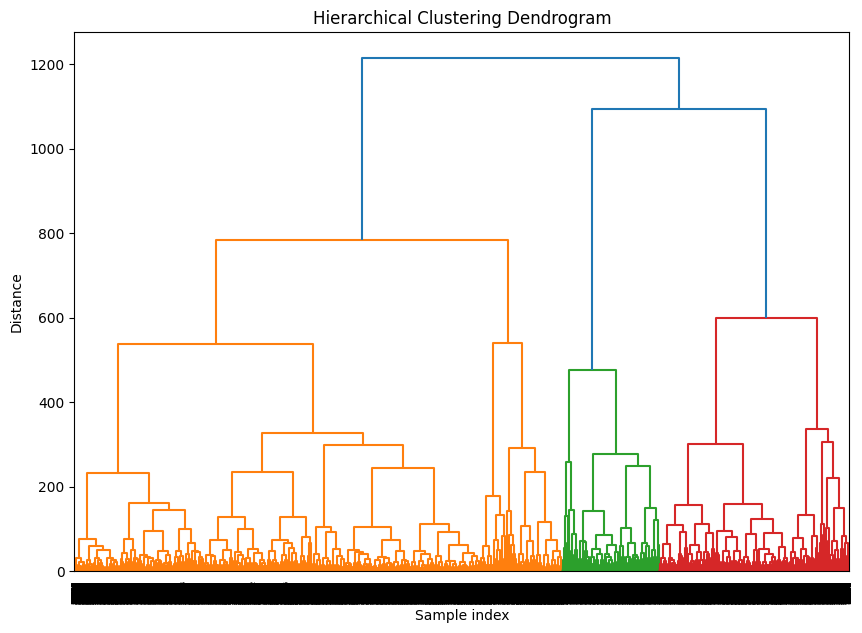

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering using 'linkage'
# The 'ward' method is often used for its good balance between speed and quality.
Z = linkage(fd_reduced, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [19]:
num_c = 4
# Apply Hierarchical Agglomerative Clustering
hac = AgglomerativeClustering(n_clusters=num_c)
cluster_labels = hac.fit_predict(fd_reduced)
df['HAC_cluster'] = cluster_labels

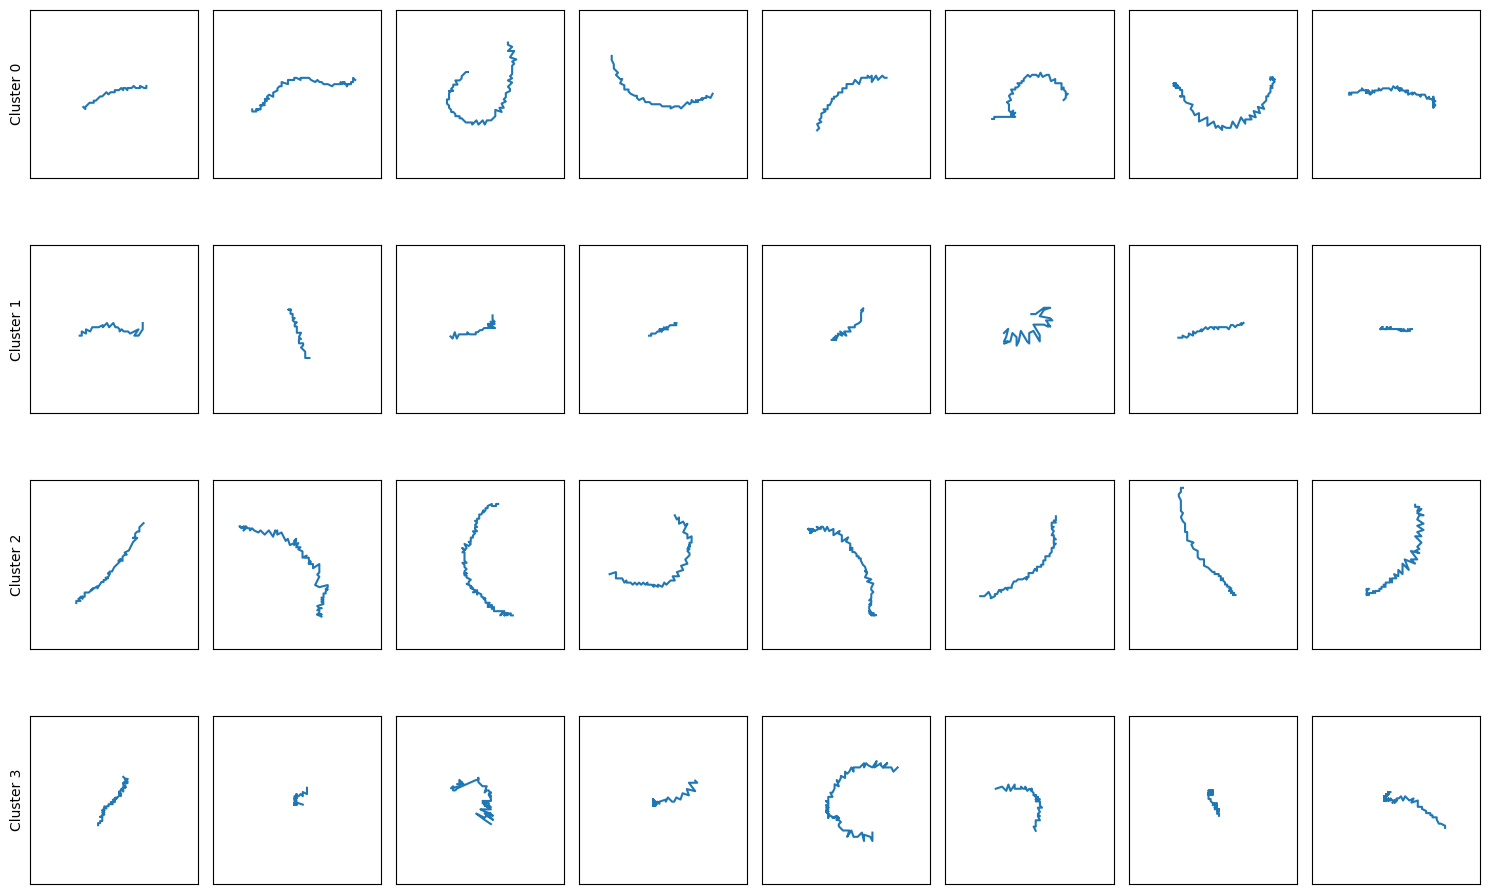

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast


n_samples = 8
# Create a figure with subplots
fig, axes = plt.subplots(num_c, n_samples, figsize=(15, 10))  # Adjust the size as needed

for i in range(num_c):
    # Select random samples from each cluster
    cluster_data = df[df['HAC_cluster'] == i].sample(n=n_samples, random_state=42)
    
    for j, (index, row) in enumerate(cluster_data.iterrows()):
        ax = axes[i][j]
        # Extract the centered trajectory
        traj_array = np.array(row['centered_traj'])
        # Plot the trajectory
        ax.plot(traj_array[:, 0], traj_array[:, 1])

        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        ax.set_aspect('equal', adjustable='box')

        # Optional: Hide x and y axis labels for clarity
        ax.set_xticks([])
        ax.set_yticks([])

    # Set y-axis label for each row
    axes[i][0].set_ylabel(f"Cluster {i}")

# Optional: adjust layout for better spacing
plt.tight_layout()
plt.show()

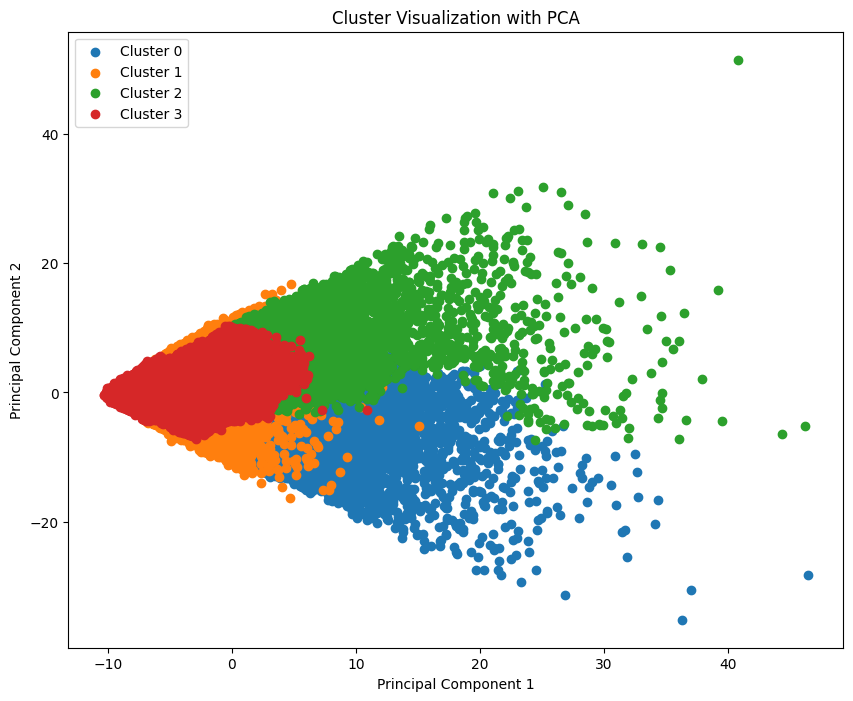

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'features' are your motility parameters
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(fd_normalized)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  
    cluster_data = reduced_features[df['HAC_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


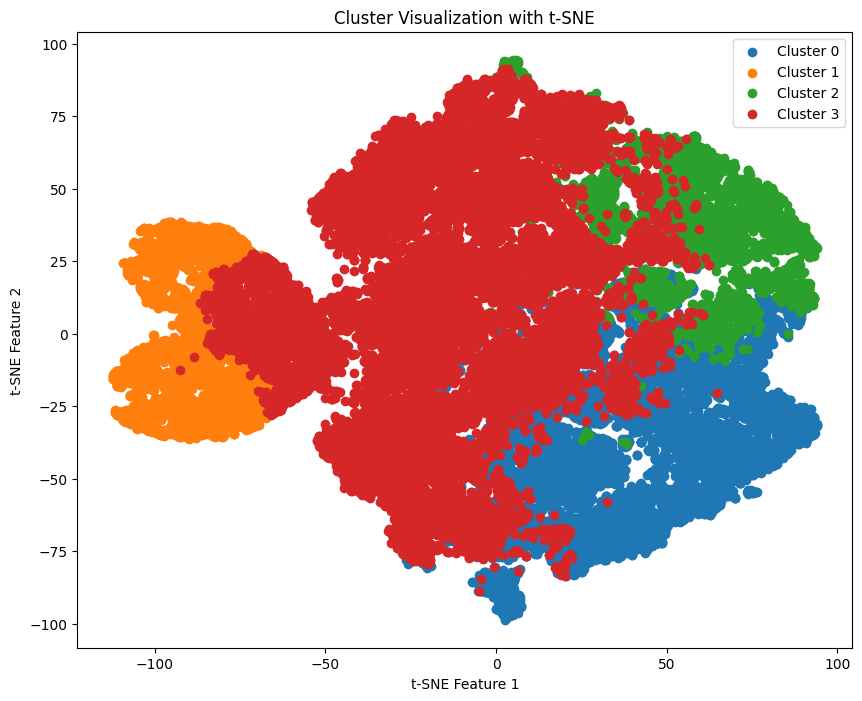

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'features' are your motility parameters
# Perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)  # random_state for reproducibility
reduced_features = tsne.fit_transform(fd_normalized)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  # Assuming there are 4 clusters
    cluster_data = reduced_features[df['HAC_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


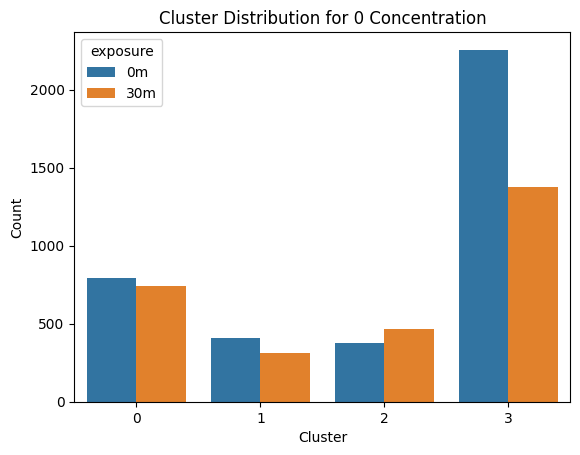

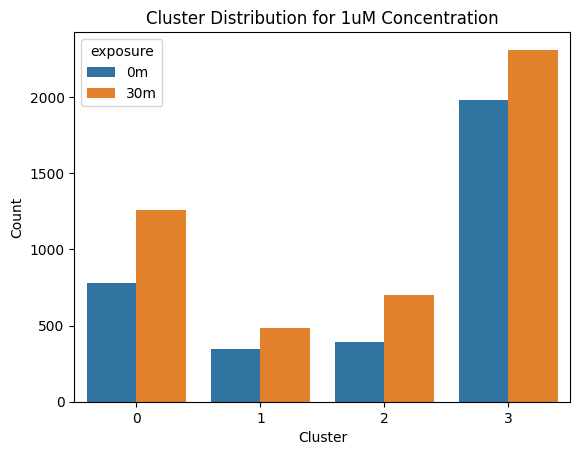

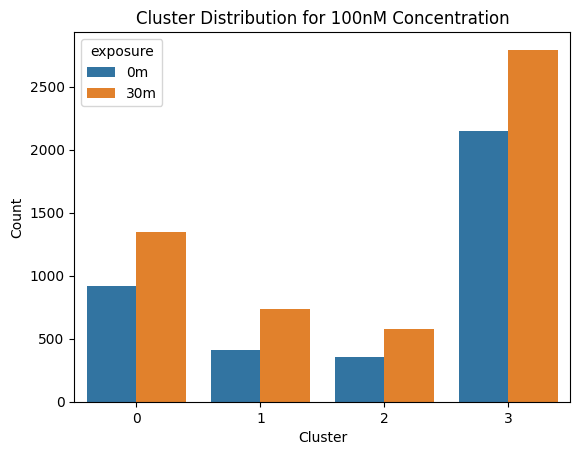

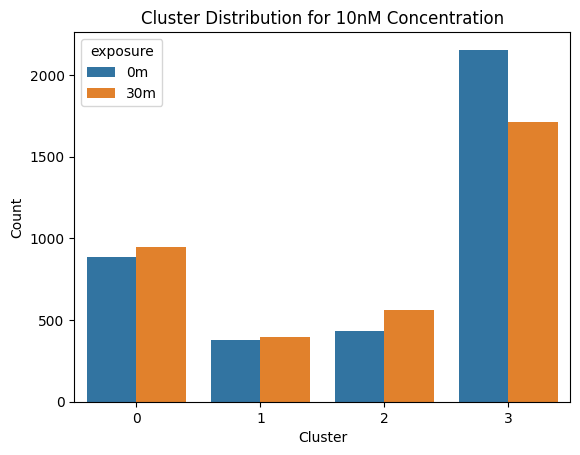

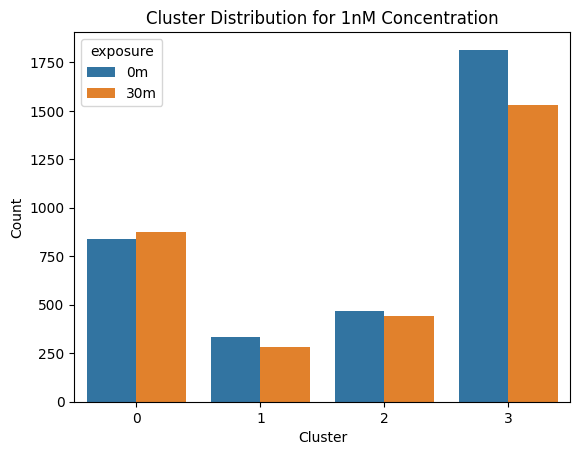

In [26]:
!pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Distribution of clusters at different time points for each concentration
def plot_cluster_distribution(df):
    for concentration in df['quantity'].unique():
        subset = df[df['quantity'] == concentration]
        sns.countplot(x='HAC_cluster', hue='exposure', data=subset)
        plt.title(f'Cluster Distribution for {concentration} Concentration')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.show()

plot_cluster_distribution(df)

In [27]:
df['quantity'].unique()

array(['0', '1uM', '100nM', '10nM', '1nM'], dtype=object)

In [28]:
df['exposure'].unique()

array(['0m', '30m'], dtype=object)

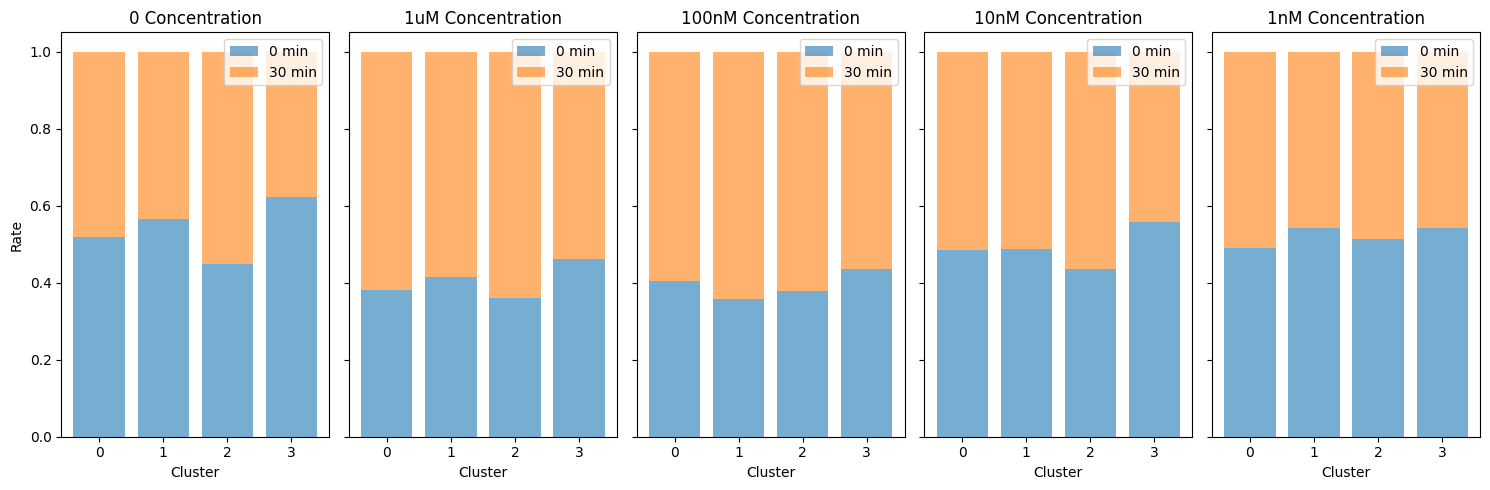

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot rate of elements in each cluster
def plot_cluster_rate(df, num_c):
    # Get unique concentrations
    concentrations = df['quantity'].unique()
    clusters = range(num_c)  # Assuming num_c is the number of clusters

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(concentrations), figsize=(15, 5), sharey=True)

    for i, concentration in enumerate(concentrations):
        subset = df[df['quantity'] == concentration]
        total = subset.groupby(['HAC_cluster'])['exposure'].count()

        # Calculate rate (proportion) of elements in each cluster at 0 and 30 minutes
        rate_0 = subset[subset['exposure'] == '0m'].groupby(['HAC_cluster'])['exposure'].count() / total
        rate_30 = subset[subset['exposure'] == '30m'].groupby(['HAC_cluster'])['exposure'].count() / total

        # Create bar plot for each concentration
        axes[i].bar(clusters, rate_0, label='0 min', alpha=0.6)
        axes[i].bar(clusters, rate_30, bottom=rate_0, label='30 min', alpha=0.6)
        axes[i].set_title(f'{concentration} Concentration')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Rate' if i == 0 else '')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_cluster_rate(df, num_c)  # Assuming num_c is the number of clusters


In [31]:
!pip install statsmodels
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross', 'ALH']

# ANOVA for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster'].unique():
    cluster_data = df[df['HAC_cluster'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        model = ols(f'{param} ~ C(quantity) * C(exposure)', data=cluster_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param}:')
        print(result)
        print()  # Adding a blank line for better readability

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 4.6 MB/s eta 0:00:00a 0:00:01
ANOVA results for Cluster 3:
ANOVA for VCL:
                               sum_sq       df           F         PR(>F)
C(quantity)              2.214207e+05      4.0   51.797722   1.798592e-43
C(exposure)              5.441551e+05      1.0  509.184507  2.318053e-111
C(quantity):C(exposure)  1.721665e+05      4.0   40.275529   1.161052e-33
Residual                 2.143664e+07  20059.0         NaN            NaN

ANOVA for VAP:
                               sum_sq       df          F        PR(>F)
C(quantity)              2.612291e+04      4.0  16.367486  2.153968e-13
C(exposure)              1.849676e+04      1.0  46.357085  1.013373e-11
C(quantity):C(exposure)  5.285526e+04      4.0  33.116825  1.427007e-27
Residual                 8.003663e+06  20059.0        NaN           NaN

ANOVA for VSL:
                 

In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy.contrasts import Helmert

# ANOVA with Helmert contrasts for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster'].unique():
    cluster_data = df[df['HAC_cluster'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        # Fitting the model with Helmert contrasts
        formula = f'{param} ~ C(quantity, Helmert()) * C(exposure)'
        model = ols(formula, data=cluster_data).fit()

        # Calculating ANOVA table with contrasts
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param} with Helmert Contrasts:')
        print(result)
        print()  # Adding a blank line for better readability


ANOVA results for Cluster 3:
ANOVA for VCL with Helmert Contrasts:
                                          sum_sq       df           F  \
C(quantity, Helmert())              2.214207e+05      4.0   51.797722   
C(exposure)                         5.441551e+05      1.0  509.184507   
C(quantity, Helmert()):C(exposure)  1.721665e+05      4.0   40.275529   
Residual                            2.143664e+07  20059.0         NaN   

                                           PR(>F)  
C(quantity, Helmert())               1.798592e-43  
C(exposure)                         2.318053e-111  
C(quantity, Helmert()):C(exposure)   1.161052e-33  
Residual                                      NaN  

ANOVA for VAP with Helmert Contrasts:
                                          sum_sq       df          F  \
C(quantity, Helmert())              2.612291e+04      4.0  16.367486   
C(exposure)                         1.849676e+04      1.0  46.357085   
C(quantity, Helmert()):C(exposure)  5.285526e+04    

In [33]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming 'df' is your DataFrame and it includes 'HAC_cluster', 'quantity', and motility parameters

# Loop through each cluster
for cluster in df['HAC_cluster'].unique():
    print(f"Cluster {cluster} Analysis:\n")
    cluster_data = df[df['HAC_cluster'] == cluster]
    
    # Loop through each motility parameter
    for param in motility_parameters:
        print(f"Post-hoc Analysis for {param}:\n")
        
        # Fit the model
        model = ols(f'{param} ~ C(quantity)', data=cluster_data).fit()
        
        # Perform ANOVA
        anova_results = sm.stats.anova_lm(model, typ=2)
        
        # Display ANOVA table
        print("ANOVA Table:")
        print(anova_results)
        print("\n")
        
        # Tukey's HSD post-hoc test for pairwise comparisons
        tukey = pairwise_tukeyhsd(endog=cluster_data[param],     # Data
                                  groups=cluster_data['quantity'],   # Groups
                                  alpha=0.05)                   # Significance level

        # Display Tukey's test results
        print("Tukey's HSD Results:")
        print(tukey)
        print("\n" + "-"*50 + "\n")


Cluster 3 Analysis:

Post-hoc Analysis for VCL:

ANOVA Table:
                   sum_sq       df          F        PR(>F)
C(quantity)  2.468574e+05      4.0  55.894852  5.839251e-47
Residual     2.215296e+07  20064.0        NaN           NaN


Tukey's HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0  100nM  -7.3689    0.0  -9.3503 -5.3875   True
     0   10nM  -8.0082    0.0 -10.1035 -5.9129   True
     0    1nM -10.9111    0.0 -13.0838 -8.7383   True
     0    1uM  -4.4033    0.0  -6.4473 -2.3593   True
 100nM   10nM  -0.6393 0.8985  -2.5861  1.3075  False
 100nM    1nM  -3.5422    0.0  -5.5722 -1.5122   True
 100nM    1uM   2.9656 0.0002    1.074  4.8571   True
  10nM    1nM  -2.9029  0.002  -5.0441 -0.7616   True
  10nM    1uM   3.6049    0.0   1.5944  5.6153   True
   1nM    1uM   6.5077    0.0   4.4166  8.5989   True
---------------------------------